# Data preprocessing for Fusion and Model

Importing Libraries

In [32]:
# Essentials
import pandas as pd
import numpy as np

# Processing
from sklearn.preprocessing import StandardScaler

# Model

# Visualization

# Warnings
import warnings
warnings.filterwarnings('ignore')

Loading Datasets

In [33]:
# Clinical Datasets
African = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/African_pro.csv")
Bangladesh = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/Bangladesh_pro.csv")
Iraq = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/Iraq_pro.csv")

# Genetic Datasets
inter_genetic = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/genetic/inter_genetic_dataset.csv")
normal_genetic = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/genetic/normal_genetic_dataset.csv")

Checking Target Columns

In [34]:
print(African.columns, "\n")
print(Bangladesh.columns, "\n")
print(Iraq.columns, "\n")
print(inter_genetic.columns, "\n")
print(normal_genetic.columns)

Index(['Cholesterol', 'Glucose', 'HDL Chol', 'Chol/HDL ratio', 'Age', 'Gender',
       'Height', 'Weight', 'BMI', 'Systolic BP', 'Diastolic BP', 'waist',
       'hip', 'Waist/hip ratio', 'Diabetes'],
      dtype='object') 

Index(['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height',
       'weight', 'bmi', 'family_diabetes', 'hypertensive',
       'family_hypertension', 'cardiovascular_disease', 'stroke',
       'gender_Encoded', 'diabetic_Encoded'],
      dtype='object') 

Index(['Age', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
       'Gender_Encoded', 'Class_Encoded'],
      dtype='object') 

Index(['STUDY', 'DISEASE_DESCRIPTION', 'REGION', 'CHR_ID', 'CHR_POS',
       'MAPPED_GENE', 'UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID',
       'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE', 'SNPS', 'MERGED',
       'GENOMIC_CONTEXT', 'INTERGENIC', 'RISK_ALLELE_FREQUENCY', 'PVALUE',
       'PVALUE_MLOG', 'EFFECT_SIZE', 'CASE_PERCENTAGE', 'CI_LOWER_

Uniting Target Columns' name

Checking Data Types 

In [35]:
print(African.dtypes, '\n')
print(Bangladesh.dtypes, '\n')
print(Iraq.dtypes, '\n')
print(inter_genetic.dtypes, '\n')
print(normal_genetic.dtypes, '\n')

Cholesterol          int64
Glucose              int64
HDL Chol             int64
Chol/HDL ratio     float64
Age                  int64
Gender               int64
Height               int64
Weight               int64
BMI                float64
Systolic BP          int64
Diastolic BP         int64
waist                int64
hip                  int64
Waist/hip ratio    float64
Diabetes             int64
dtype: object 

age                         int64
pulse_rate                  int64
systolic_bp                 int64
diastolic_bp                int64
glucose                   float64
height                    float64
weight                    float64
bmi                       float64
family_diabetes             int64
hypertensive                int64
family_hypertension         int64
cardiovascular_disease      int64
stroke                      int64
gender_Encoded              int64
diabetic_Encoded            int64
dtype: object 

Age                 int64
Urea              float64
C

Checking number of columns and rows

In [36]:
print(African.shape, '\n')
print(Bangladesh.shape, '\n')
print(Iraq.shape, '\n')
print(inter_genetic.shape, '\n')
print(normal_genetic.shape, '\n')

(390, 15) 

(5437, 15) 

(786, 12) 

(1110, 28) 

(2141, 25) 



In [37]:
African.rename(columns={
    'Diabetes': 'T2D',
}, inplace=True)
 
Bangladesh.rename(columns={
    'diabetic_Encoded': 'T2D',
}, inplace=True)
 
Iraq.rename(columns={
    'Class_Encoded': 'T2D',
}, inplace=True)
 
# Add a new column 'T2D' with all values set to 1
#inter_genetic['T2D'] = 1
 
# Add a new column 'T2D' with all values set to 1
#normal_genetic['T2D'] = 1

#  Imports & Target Renaming


In [38]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, confusion_matrix
)

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam

# Rename clinical targets to 'T2D'
African.rename(columns={'Diabetes':'T2D'},      inplace=True)
Bangladesh.rename(columns={'diabetic_Encoded':'T2D'}, inplace=True)
Iraq.rename(columns={'Class_Encoded':'T2D'},    inplace=True)

# Ensure genetic sets have a 'T2D' column (all positives)
for df in (inter_genetic, normal_genetic):
    if 'T2D' not in df.columns:
        df['T2D'] = 1


# Clinical Train/Val/Test Split


In [39]:
test_size_clin = 0.20
val_size_clin  = 0.15
rs             = 42

def split_clinical(df):
    X_tr_val, X_test, y_tr_val, y_test = train_test_split(
        df.drop(columns='T2D'), df['T2D'],
        test_size=test_size_clin, stratify=df['T2D'], random_state=rs
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_tr_val, y_tr_val,
        test_size=val_size_clin, stratify=y_tr_val, random_state=rs
    )
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train_african, y_train_african, X_val_african, y_val_african, X_test_african, y_test_african = split_clinical(African)
X_train_bangladesh, y_train_bangladesh, X_val_bangladesh, y_val_bangladesh, X_test_bangladesh, y_test_bangladesh = split_clinical(Bangladesh)
X_train_iraq,       y_train_iraq,       X_val_iraq,       y_val_iraq,       X_test_iraq,       y_test_iraq       = split_clinical(Iraq)


# Clinical Preprocessing (Scaling & Imputation)


In [40]:

imputer = SimpleImputer(strategy='mean')

def preprocess_clinical(X_train, X_val, X_test):
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    scaler   = StandardScaler().fit(X_train[num_cols])
    X_tr_sc   = scaler.transform(X_train[num_cols])
    X_val_sc  = scaler.transform(X_val[num_cols])
    X_test_sc = scaler.transform(X_test[num_cols])
    return (
        imputer.fit_transform(X_tr_sc),
        imputer.transform(X_val_sc),
        imputer.transform(X_test_sc)
    )

X_train_african_sc, X_val_african_sc, X_test_african_sc = preprocess_clinical(
    X_train_african, X_val_african, X_test_african
)
X_train_bangladesh_sc, X_val_bangladesh_sc, X_test_bangladesh_sc = preprocess_clinical(
    X_train_bangladesh, X_val_bangladesh, X_test_bangladesh
)
X_train_iraq_sc, X_val_iraq_sc, X_test_iraq_sc = preprocess_clinical(
    X_train_iraq, X_val_iraq, X_test_iraq
)


#  GAN & Balancing Utilities


In [41]:
def build_generator(input_dim, output_dim):
    return Sequential([
        Dense(128, input_dim=input_dim), LeakyReLU(0.2), BatchNormalization(),
        Dense(256),                      LeakyReLU(0.2), BatchNormalization(),
        Dense(output_dim, activation='tanh')
    ])

def build_discriminator(input_dim):
    disc = Sequential([
        Dense(256, input_dim=input_dim), LeakyReLU(0.2),
        Dense(128),                       LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
    ])
    disc.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return disc

def generate_synthetic_negatives(real_df, generator, scaler, num_cols, label_col='T2D'):
    n = len(real_df)
    # 1) Generate fake features
    z    = np.random.normal(0, 1, (n, generator.input_shape[1])).astype(np.float32)
    fake = generator.predict(z, verbose=0)
    # 2) Inverse‐scale numeric
    synth_num = scaler.inverse_transform(fake)
    synth_df  = pd.DataFrame(synth_num, columns=num_cols)
    synth_df[label_col] = 0
    # 3) Real positives (numeric only)
    pos_df = real_df[num_cols + [label_col]].copy()
    # 4) Combine
    balanced = pd.concat([pos_df, synth_df], ignore_index=True)
    X = balanced[num_cols]      # drop any stray non-numeric
    y = balanced[label_col]
    return X, y


#  Genetic Processing (Split, GAN, Balance)


In [42]:
def process_genetic(
    df,
    test_size,
    val_size,
    rs,
    noise_dim=100,
    epochs=500,    
    batch_size=64
):
    # A) Split real positives into train+val vs test
    X_all = df.drop(columns='T2D')
    y_all = df['T2D']
    X_tr_val, X_test, y_tr_val, y_test = train_test_split(
        X_all, y_all, test_size=test_size, stratify=y_all, random_state=rs
    )
    # B) From train+val, carve out validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_tr_val, y_tr_val, test_size=val_size, stratify=y_tr_val, random_state=rs
    )
    # C) Numeric features only
    num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
    # D) Scale training positives
    scaler = MinMaxScaler().fit(X_train[num_cols])
    train_scaled = scaler.transform(X_train[num_cols]).astype(np.float32)
    # E) Build & compile GAN
    generator     = build_generator(noise_dim, train_scaled.shape[1])
    discriminator = build_discriminator(train_scaled.shape[1])
    discriminator.trainable = False
    gan = Sequential([generator, discriminator])
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    # F) Train GAN (fewer epochs to avoid collapse)
    for ep in range(epochs):
        idx   = np.random.randint(0, len(train_scaled), batch_size)
        real  = train_scaled[idx]
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake  = generator.predict(noise, verbose=0)
        discriminator.trainable = True
        discriminator.train_on_batch(real, np.ones((batch_size, 1)))
        discriminator.train_on_batch(fake, np.zeros((batch_size, 1)))
        discriminator.trainable = False
        gan.train_on_batch(
            np.random.normal(0, 1, (batch_size, noise_dim)),
            np.ones((batch_size, 1))
        )
        if ep % 50 == 0:   # adjust print interval to match your new epoch count
            print(f"[GAN] Epoch {ep}/{epochs}")
    # G) Generate balanced splits
    X_tr_bal, y_tr_bal = generate_synthetic_negatives(
        pd.concat([X_train, y_train], axis=1),
        generator, scaler, num_cols
    )
    X_val_bal, y_val_bal = generate_synthetic_negatives(
        pd.concat([X_val, y_val], axis=1),
        generator, scaler, num_cols
    )
    X_te_bal, y_te_bal = generate_synthetic_negatives(
        pd.concat([X_test, y_test], axis=1),
        generator, scaler, num_cols
    )
    return X_tr_bal, y_tr_bal, X_val_bal, y_val_bal, X_te_bal, y_te_bal

# New genetic split sizes
test_size_gen = 0.20
val_size_gen  = 0.10 / (1 - test_size_gen)  # ≈0.125

# Process inter_genetic & normal_genetic, using the new default of 200 epochs
X_train_inter, y_train_inter, X_val_inter, y_val_inter, X_test_inter, y_test_inter = \
    process_genetic(inter_genetic, test_size_gen, val_size_gen, rs)

X_train_normal, y_train_normal, X_val_normal, y_val_normal, X_test_normal, y_test_normal = \
    process_genetic(normal_genetic, test_size_gen, val_size_gen, rs)


[GAN] Epoch 0/500
[GAN] Epoch 50/500
[GAN] Epoch 100/500
[GAN] Epoch 150/500
[GAN] Epoch 200/500
[GAN] Epoch 250/500
[GAN] Epoch 300/500
[GAN] Epoch 350/500
[GAN] Epoch 400/500
[GAN] Epoch 450/500
[GAN] Epoch 0/500
[GAN] Epoch 50/500
[GAN] Epoch 100/500
[GAN] Epoch 150/500
[GAN] Epoch 200/500
[GAN] Epoch 250/500
[GAN] Epoch 300/500
[GAN] Epoch 350/500
[GAN] Epoch 400/500
[GAN] Epoch 450/500


# Define Models & Assemble Datasets


In [43]:
best_models = {
    "African":       GradientBoostingClassifier(random_state=rs),
    "Bangladesh":    RandomForestClassifier(random_state=rs),
    "Iraq":          LogisticRegression(random_state=rs, max_iter=1000),
    "InterGenetic":  LogisticRegression(random_state=rs, max_iter=1000),
    "NormalGenetic": LogisticRegression(random_state=rs, max_iter=1000),
}

datasets = {
    "African":       (X_train_african_sc, y_train_african, X_val_african_sc, y_val_african, X_test_african_sc, y_test_african),
    "Bangladesh":    (X_train_bangladesh_sc, y_train_bangladesh, X_val_bangladesh_sc, y_val_bangladesh, X_test_bangladesh_sc, y_test_bangladesh),
    "Iraq":          (X_train_iraq_sc, y_train_iraq, X_val_iraq_sc, y_val_iraq, X_test_iraq_sc, y_test_iraq),
    "InterGenetic":  (X_train_inter, y_train_inter, X_val_inter, y_val_inter, X_test_inter, y_test_inter),
    "NormalGenetic": (X_train_normal, y_train_normal, X_val_normal, y_val_normal, X_test_normal, y_test_normal),
}


# Train & Evaluate All Models


In [44]:
for name, (X_tr, y_tr, X_val, y_val, X_te, y_te) in datasets.items():
    clf = best_models[name]
    clf.fit(X_tr, y_tr)

    # Validation
    yv_pred  = clf.predict(X_val)
    yv_proba = clf.predict_proba(X_val)[:,1] if hasattr(clf, "predict_proba") else np.zeros_like(yv_pred, float)
    print(f"\n{name} — Validation — "
          f"Acc={accuracy_score(y_val, yv_pred):.3f}, "
          f"ROC AUC={roc_auc_score(y_val, yv_proba):.3f}, "
          f"PR AUC={average_precision_score(y_val, yv_proba):.3f}")

    # Test
    yt_pred  = clf.predict(X_te)
    yt_proba = clf.predict_proba(X_te)[:,1] if hasattr(clf, "predict_proba") else np.zeros_like(yt_pred, float)
    print(f"{name} — Test       — "
          f"Acc={accuracy_score(y_te, yt_pred):.3f}, "
          f"ROC AUC={roc_auc_score(y_te, yt_proba):.3f}, "
          f"PR AUC={average_precision_score(y_te, yt_proba):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, yt_pred))



African — Validation — Acc=0.915, ROC AUC=0.830, PR AUC=0.697
African — Test       — Acc=0.872, ROC AUC=0.926, PR AUC=0.685
Confusion Matrix:
[[61  5]
 [ 5  7]]

Bangladesh — Validation — Acc=0.948, ROC AUC=0.868, PR AUC=0.531
Bangladesh — Test       — Acc=0.943, ROC AUC=0.861, PR AUC=0.388
Confusion Matrix:
[[1012    7]
 [  55   14]]

Iraq — Validation — Acc=0.968, ROC AUC=0.989, PR AUC=0.955
Iraq — Test       — Acc=0.962, ROC AUC=0.988, PR AUC=0.933
Confusion Matrix:
[[136   3]
 [  3  16]]

InterGenetic — Validation — Acc=0.860, ROC AUC=0.904, PR AUC=0.873
InterGenetic — Test       — Acc=0.867, ROC AUC=0.929, PR AUC=0.923
Confusion Matrix:
[[187  35]
 [ 24 198]]

NormalGenetic — Validation — Acc=0.727, ROC AUC=0.797, PR AUC=0.797
NormalGenetic — Test       — Acc=0.706, ROC AUC=0.753, PR AUC=0.771
Confusion Matrix:
[[294 135]
 [117 312]]


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics        import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# 1) Unpack Iraq’s pre-split arrays:
X_tr_iraq, y_tr_iraq, X_val_iraq, y_val_iraq, X_te_iraq, y_te_iraq = datasets["Iraq"]

# 2) Combine train+val for cross-validation:
import numpy as np
X_trainval_iraq = np.vstack([X_tr_iraq, X_val_iraq])
y_trainval_iraq = np.concatenate([y_tr_iraq, y_val_iraq])

# 3) Run 5-fold Stratified CV with a simple baseline:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
cv_scores = []
for fold, (idx_tr, idx_te) in enumerate(skf.split(X_trainval_iraq, y_trainval_iraq), 1):
    X_tr_fold, X_te_fold = X_trainval_iraq[idx_tr], X_trainval_iraq[idx_te]
    y_tr_fold, y_te_fold = y_trainval_iraq[idx_tr], y_trainval_iraq[idx_te]

    lr = LogisticRegression(max_iter=1_000, random_state=rs)
    lr.fit(X_tr_fold, y_tr_fold)
    y_pred = lr.predict_proba(X_te_fold)[:,1]
    score  = roc_auc_score(y_te_fold, y_pred)
    print(f"Fold {fold} AUC: {score:.3f}")
    cv_scores.append(score)

print("Mean CV AUC:", np.mean(cv_scores))

# 4) Finally, test on the held-out test set:
final_clf = LogisticRegression(max_iter=1_000, random_state=rs)
final_clf.fit(X_trainval_iraq, y_trainval_iraq)
y_test_pred = final_clf.predict_proba(X_te_iraq)[:,1]
print("Held-out Test AUC:", roc_auc_score(y_te_iraq, y_test_pred))


Fold 1 AUC: 0.987
Fold 2 AUC: 0.993
Fold 3 AUC: 0.997
Fold 4 AUC: 0.999
Fold 5 AUC: 0.994
Mean CV AUC: 0.9939751569751569
Held-out Test AUC: 0.9878833775085195


## Subplots of Cross Validation for the best model

In [46]:
import numpy as np
from sklearn.model_selection import cross_val_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ── 1) Best models mapping (reuse from earlier) ───────────────────────────────
best_models_mapping = {
    "African":       GradientBoostingClassifier(random_state=rs),
    "Bangladesh":    RandomForestClassifier(random_state=42),
    "Iraq":          LogisticRegression(random_state=42, max_iter=1000),
    "InterGenetic":  LogisticRegression(random_state=42, max_iter=1000),
    "NormalGenetic": LogisticRegression(random_state=42, max_iter=1000),
}

# ── 2) CV datasets using our preprocessed training splits ──────────────────────
cv_datasets = {
    "African":       (X_train_african_sc,    y_train_african),
    "Bangladesh":    (X_train_bangladesh_sc, y_train_bangladesh),
    "Iraq":          (X_train_iraq_sc,       y_train_iraq),
    "InterGenetic":  (X_train_inter,         y_train_inter),
    "NormalGenetic": (X_train_normal,        y_train_normal),
}

cv_folds  = 10
cv_scores = {}

# ── 3) Perform cross-validation ────────────────────────────────────────────────
for name, (X_tr, y_tr) in cv_datasets.items():
    model = best_models_mapping[name]
    scores = cross_val_score(model, X_tr, y_tr, cv=cv_folds)
    cv_scores[name] = scores

# ── 4) Build subplots ─────────────────────────────────────────────────────────
fig = make_subplots(
    rows=len(cv_datasets), cols=1, shared_xaxes=True,
    subplot_titles=[
        f"{name} ({best_models_mapping[name].__class__.__name__}) CV Scores"
        for name in cv_datasets
    ]
)

# ── 5) Plot each dataset’s fold scores ────────────────────────────────────────
for i, (name, scores) in enumerate(cv_scores.items(), start=1):
    fig.add_trace(
        go.Scatter(
            x=list(range(1, cv_folds + 1)),
            y=scores,
            mode='lines+markers',
            name=name
        ),
        row=i, col=1
    )

# ── 6) Layout tweaks ──────────────────────────────────────────────────────────
fig.update_layout(
    height=300 * len(cv_datasets),
    width=800,
    title_text="10-Fold Cross-Validation Accuracy for Best Models",
    showlegend=False
)
fig.update_xaxes(title_text="Fold #")
fig.update_yaxes(title_text="Accuracy")

fig.show()



ROC Curves for Best Models

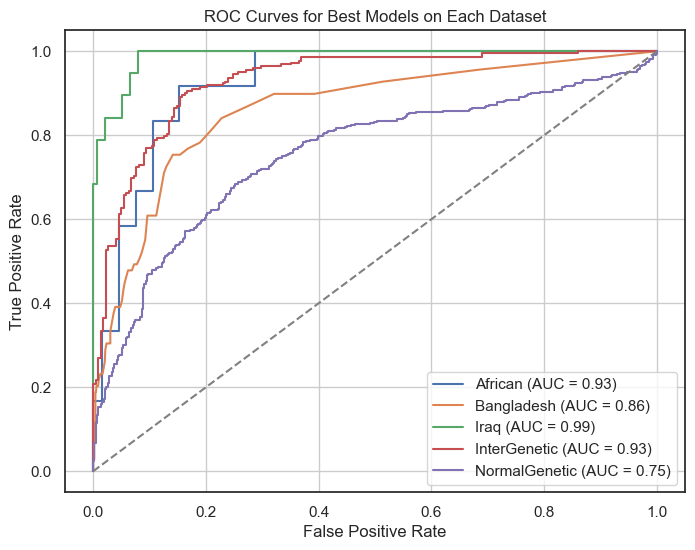

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ── 1) Prepare ROC datasets using our preprocessed splits ─────────────────────
roc_datasets = {
    "African":       (X_train_african_sc,    X_test_african_sc,    y_train_african,    y_test_african),
    "Bangladesh":    (X_train_bangladesh_sc, X_test_bangladesh_sc, y_train_bangladesh, y_test_bangladesh),
    "Iraq":          (X_train_iraq_sc,       X_test_iraq_sc,       y_train_iraq,       y_test_iraq),
    "InterGenetic":  (X_train_inter,         X_test_inter,         y_train_inter,      y_test_inter),
    "NormalGenetic": (X_train_normal,        X_test_normal,        y_train_normal,     y_test_normal),
}

# ── 2) Compute ROC curve & AUC for each dataset’s best model ───────────────────
roc_data = {}
for name, (X_tr, X_te, y_tr, y_te) in roc_datasets.items():
    model = best_models_mapping[name]
    model.fit(X_tr, y_tr)                         # train on train split
    y_prob = model.predict_proba(X_te)[:, 1]      # probability for positive class
    fpr, tpr, _ = roc_curve(y_te, y_prob)         # ROC points
    roc_auc = auc(fpr, tpr)                      # AUC value
    roc_data[name] = (fpr, tpr, roc_auc)

# ── 3) Plot all ROC curves together ────────────────────────────────────────────
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.2f})")

# Diagonal “chance” line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Best Models on Each Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Feature Importance

In [48]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# ——— Assemble scaled features + original DataFrames for column names ——————
datasets_scaled = {
    "African":       (X_train_african_sc,    y_train_african,    X_train_african),
    "Bangladesh":    (X_train_bangladesh_sc, y_train_bangladesh, X_train_bangladesh),
    "Iraq":          (X_train_iraq_sc,       y_train_iraq,       X_train_iraq),
    "InterGenetic":  (X_train_inter,         y_train_inter,      X_train_inter),
    "NormalGenetic": (X_train_normal,        y_train_normal,     X_train_normal),
}

feature_importance_results = {}

for name, (X_scaled, y, X_df) in datasets_scaled.items():
    # Train the RandomForest on the scaled features
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_scaled, y)
    
    # Get numeric feature names
    numeric_cols = list(X_df.select_dtypes(include=[np.number]).columns)
    
    # Map importances back to column names
    imps = pd.Series(rf.feature_importances_, index=numeric_cols)
    
    # Sort descending
    feature_importance_results[name] = imps.sort_values(ascending=False)

# Print the top 5 features for each dataset
for name, fi in feature_importance_results.items():
    print(f"\n=== Top 5 features for {name} ===")
    print(fi.head(5))



=== Top 5 features for African ===
Glucose           0.432203
Systolic BP       0.077199
Chol/HDL ratio    0.067734
Age               0.066576
BMI               0.052574
dtype: float64

=== Top 5 features for Bangladesh ===
glucose         0.227721
bmi             0.110965
systolic_bp     0.097392
weight          0.096648
diastolic_bp    0.094721
dtype: float64

=== Top 5 features for Iraq ===
HbA1c    0.328009
BMI      0.263869
Chol     0.115911
Age      0.115452
LDL      0.044690
dtype: float64

=== Top 5 features for InterGenetic ===
IMPUTED_ENCODED                 0.245579
PLATFORM_AFFYMETRIX_ILLUMINA    0.137572
PLATFORM_AFFYMETRIX             0.115979
EFFECT_SIZE                     0.109930
PLATFORM_ILLUMINA               0.071949
dtype: float64

=== Top 5 features for NormalGenetic ===
IMPUTED_ENCODED                 0.253043
PLATFORM_AFFYMETRIX_ILLUMINA    0.168151
MERGED                          0.122769
INTERGENIC                      0.122765
PLATFORM_AFFYMETRIX           

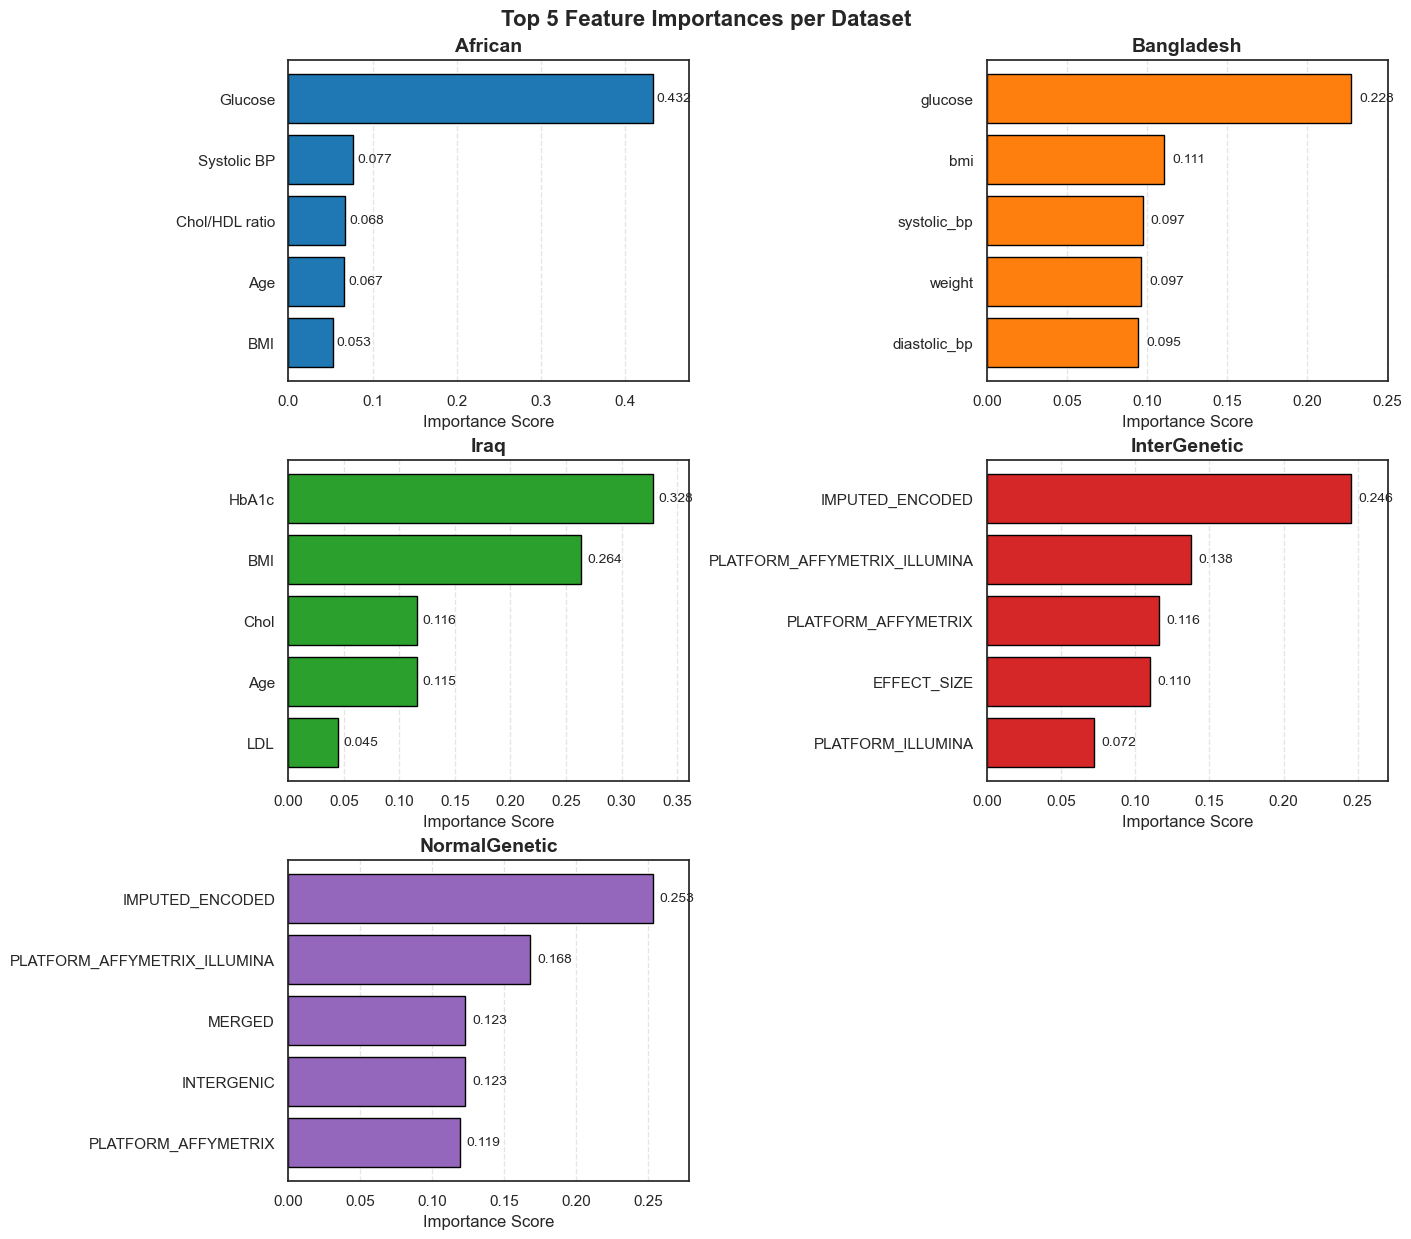

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil

# Use a clean style
sns.set(style="white")

# Number of top features to show
top_n = 5

# Prepare subplots: 2 columns
n_datasets = len(feature_importance_results)
n_cols = 2
n_rows = ceil(n_datasets / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), constrained_layout=True)
axes = axes.flatten()

# A distinct color for each dataset
palette = sns.color_palette("tab10", n_colors=n_datasets)

for idx, ((dataset_name, fi_series), ax) in enumerate(zip(feature_importance_results.items(), axes)):
    # Take top_n and reverse for horizontal bar chart
    top_features = fi_series.head(top_n)[::-1]
    
    # Plot
    ax.barh(top_features.index, top_features.values, color=palette[idx], edgecolor="black")
    
    # Annotate values
    for i, v in enumerate(top_features.values):
        ax.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)
    
    # Titles and labels
    ax.set_title(dataset_name, fontsize=14, weight="bold")
    ax.set_xlabel("Importance Score", fontsize=12)
    ax.set_ylabel("")  # feature names on y-axis are clear
    
    # Consistent x-axis across subplots
    ax.set_xlim(0, max(fi_series.head(top_n).values) * 1.1)
    
    # Light grid
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.grid(False)

# Turn off any extra axes
for ax in axes[n_datasets:]:
    ax.axis('off')

plt.suptitle("Top 5 Feature Importances per Dataset", fontsize=16, weight="bold", y=1.02)
plt.show()


# Data Fusion

Epoch 1/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.5312 - auc: 0.5490 - loss: 0.8800 - precision: 0.5556 - recall: 0.5882Epoch 001 | loss=0.8766, acc=0.5311 | val_loss=0.8044, val_acc=0.5185 | 6.26s
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5147 - auc: 0.5142 - loss: 0.8833 - precision: 0.5416 - recall: 0.5436 - val_accuracy: 0.5185 - val_auc: 0.5137 - val_loss: 0.8044 - val_precision: 0.5333 - val_recall: 0.3902 - learning_rate: 1.0000e-04
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4688 - auc: 0.5000 - loss: 0.8738 - precision: 0.5625 - recall: 0.4737Epoch 002 | loss=0.8617, acc=0.5124 | val_loss=0.8028, val_acc=0.5185 | 0.09s
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5026 - auc: 0.5411 - loss: 0.8668 - precision: 0.5113 - recall: 0.5222 - val_accuracy: 0.5185 - val_auc: 0.5137 - val_loss: 0.8028 - val_precision: 0.5333 - val_recall: 0.3902 - learning_rate: 1.0000e-04
Epoch 3/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accu

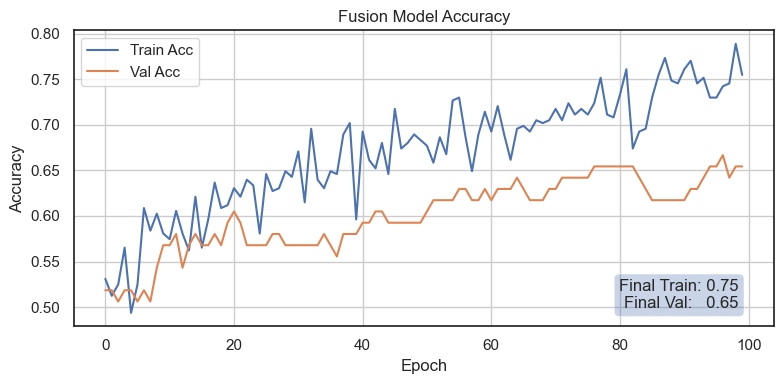

In [50]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout,
    Concatenate, Add, Multiply
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.metrics import AUC, Precision, Recall

# ── 0) Focal Loss ─────────────────────────────────────────────────────────────
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt, gamma) * bce)
    return loss_fn

rs = 42

# ── 1) Balance datasets ───────────────────────────────────────────────────────
sm = SMOTE(random_state=rs)
X_bal, y_bal = {}, {}

X_bal["African"],    y_bal["African"]    = sm.fit_resample(X_train_african_sc,    y_train_african)
X_bal["Bangladesh"], y_bal["Bangladesh"] = sm.fit_resample(X_train_bangladesh_sc, y_train_bangladesh)
X_bal["Iraq"],       y_bal["Iraq"]       = sm.fit_resample(X_train_iraq_sc,       y_train_iraq)
X_bal["inter_genetic"],  y_bal["inter_genetic"]  = X_train_inter,  y_train_inter
X_bal["normal_genetic"], y_bal["normal_genetic"] = X_train_normal, y_train_normal

modalities = list(X_bal.keys())
held_out_data, X_down, y_down = {}, {}, {}

# ── 2) Hold out 10% per modality ─────────────────────────────────────────────
for m in modalities:
    Xb, yb = X_bal[m], y_bal[m]
    Xb_main, Xb_hold, yb_main, yb_hold = train_test_split(Xb, yb, test_size=0.10, stratify=yb, random_state=rs)
    held_out_data[m] = (Xb_hold, yb_hold)
    X_down[m], y_down[m] = Xb_main, yb_main

# ── 3) Downsample to match minimum size ──────────────────────────────────────
N_min = min(len(y_down[m]) for m in modalities)
for m in modalities:
    Xb, yb = X_down[m], y_down[m]
    if len(yb) > N_min:
        Xb_ds, _, yb_ds, _ = train_test_split(Xb, yb, train_size=N_min, stratify=yb, random_state=rs)
    else:
        Xb_ds, yb_ds = Xb, yb
    X_down[m], y_down[m] = Xb_ds, yb_ds

# ── 4) Create shared train/test splits ───────────────────────────────────────
indices = np.arange(N_min)
idx_tr, idx_te = train_test_split(indices, test_size=0.2, stratify=y_down[modalities[0]], random_state=rs)

scaled_splits = {}
for m in modalities:
    Xb = X_down[m]
    Xb_tr = Xb.iloc[idx_tr] if isinstance(Xb, pd.DataFrame) else Xb[idx_tr]
    Xb_te = Xb.iloc[idx_te] if isinstance(Xb, pd.DataFrame) else Xb[idx_te]
    scaler = StandardScaler().fit(Xb_tr)
    scaled_splits[m] = (
        scaler.transform(Xb_tr),
        scaler.transform(Xb_te),
        scaler.transform(held_out_data[m][0])
    )

X_tr_inputs = [scaled_splits[m][0] for m in modalities]
X_te_inputs = [scaled_splits[m][1] for m in modalities]
X_modality_tests = {m: scaled_splits[m][2] for m in modalities}

y_tr = y_down[modalities[0]].iloc[idx_tr] if isinstance(y_down[modalities[0]], pd.Series) else y_down[modalities[0]][idx_tr]
y_te = y_down[modalities[0]].iloc[idx_te] if isinstance(y_down[modalities[0]], pd.Series) else y_down[modalities[0]][idx_te]
y_modality_tests = {m: held_out_data[m][1] for m in modalities}

# ── 5) Define the fusion model with attention ────────────────────────────────
def build_branch(input_dim, l2_reg=1e-3):
    inp = Input(shape=(input_dim,))
    x   = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(inp)
    x   = BatchNormalization()(x)
    x   = Dropout(0.3)(x)
    x   = Dense(32, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    x   = Dropout(0.3)(x)
    proj= Dense(32, kernel_regularizer=l2(l2_reg))(inp)
    x   = Add()([x, proj])
    x   = BatchNormalization()(x)
    return inp, x

branches = [build_branch(scaled_splits[m][0].shape[1]) for m in modalities]
inputs, feats = zip(*branches)

# Step 1: merge with attention (keep this only)
merged = Concatenate()(feats)
attention = Dense(len(feats), activation="softmax", name="modality_attention")(merged)
weighted_feats = [Multiply()([feats[i], attention[:, i:i+1]]) for i in range(len(feats))]
merged = Concatenate()(weighted_feats)


x = Dense(128, activation="relu", kernel_regularizer=l2(1e-3))(merged)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
skip = Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(merged)
x = Add()([x, skip])
x = BatchNormalization()(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=list(inputs), outputs=out)
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss=focal_loss(),
    metrics=["accuracy", AUC(name="auc"), Precision(name="precision"), Recall(name="recall")]
)

# ── 6) Train model ───────────────────────────────────────────────────────────
class TimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self._start
        print(f"Epoch {epoch+1:03d} | loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f} | val_loss={logs['val_loss']:.4f}, val_acc={logs['val_accuracy']:.4f} | {dt:.2f}s")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    TimeLogger()
]

history = model.fit(
    X_tr_inputs, y_tr,
    validation_data=(X_te_inputs, y_te),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# ── 7) Plot accuracy ────────────────────────────────────────────────────────
train_final = history.history["accuracy"][-1]
val_final = history.history["val_accuracy"][-1]

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.text(0.95, 0.05, f"Final Train: {train_final:.2f}\nFinal Val:   {val_final:.2f}", transform=plt.gca().transAxes, ha="right", va="bottom", bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))
plt.title("Fusion Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Accuracy on Held-Out 10% from Each Modality
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
African         Accuracy: 0.7778 | Samples: 45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Bangladesh      Accuracy: 0.4834 | Samples: 693
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iraq            Accuracy: 0.5000 | Samples: 94
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
inter_genetic   Accuracy: 0.5385 | Samples: 156
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
normal_genetic  Accuracy: 0.5000 | Samples: 300


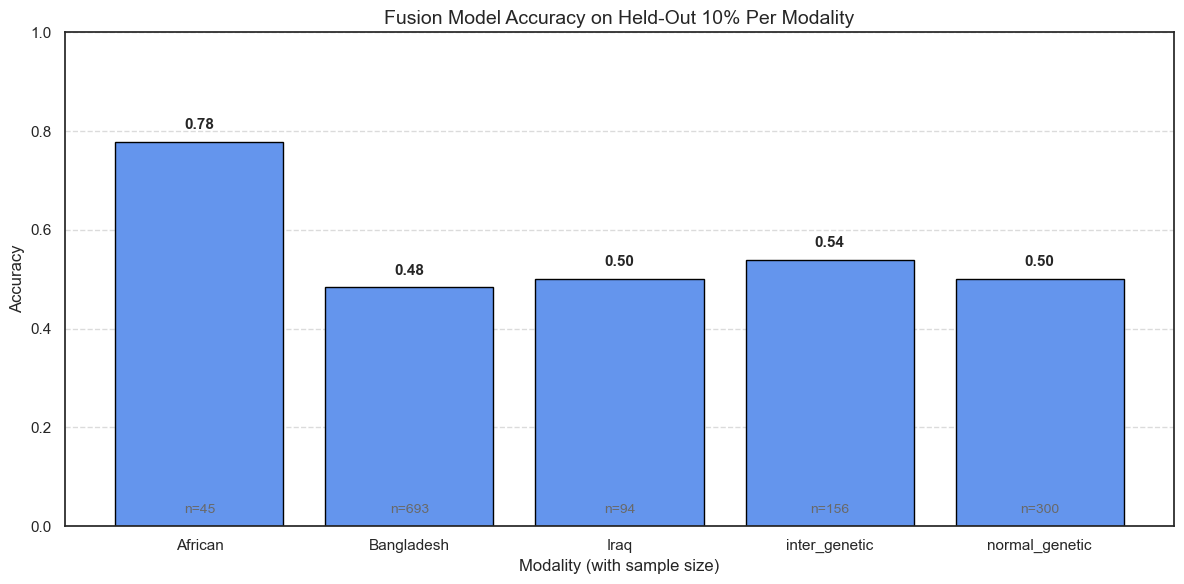

In [51]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# ── 1. Evaluate accuracy and collect sample sizes ───────────────────────────────
accuracies = []
row_counts = []

print("📊 Accuracy on Held-Out 10% from Each Modality")
for m in modalities:
    n_samples = X_modality_tests[m].shape[0]
    row_counts.append(n_samples)

    X_test = []
    for k in modalities:
        if k == m:
            X_test.append(X_modality_tests[k])
        else:
            shape = (n_samples, X_modality_tests[k].shape[1])
            X_test.append(np.zeros(shape))

    y_true = y_modality_tests[m]
    y_pred = (model.predict(X_test).flatten() >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    accuracies.append((m, acc))
    print(f"{m:<15} Accuracy: {acc:.4f} | Samples: {n_samples}")

# ── 2. Plot accuracy per modality with sample counts ─────────────────────────────
labels, acc_values = zip(*accuracies)

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, acc_values, color='cornflowerblue', edgecolor='black')

plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Modality (with sample size)', fontsize=12)
plt.title('Fusion Model Accuracy on Held-Out 10% Per Modality', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with accuracy and row count
for bar, acc, count in zip(bars, acc_values, row_counts):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.02, f"{acc:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x, 0.02, f"n={count}", ha='center', va='bottom', fontsize=10, color='dimgray')

plt.tight_layout()
plt.show()


In [52]:
import pandas as pd




# Lowercase all column names
African.columns = African.columns.str.lower()
Bangladesh.columns = Bangladesh.columns.str.lower()
Iraq.columns = Iraq.columns.str.lower()

# Renaming maps to unify similar features
rename_map_african = {
    'systolic bp': 'systolic_bp',
    'diastolic bp': 'diastolic_bp'
    # Note: 'hdl chol' is kept as-is
}

rename_map_bangladesh = {
    'gender_encoded': 'gender',
    'systolic_bp': 'systolic_bp',
    'diastolic_bp': 'diastolic_bp'
}

rename_map_iraq = {
    'gender_encoded': 'gender',
    'chol': 'cholesterol'
    # Note: 'hdl' is kept as-is
}

# Apply renaming
African = African.rename(columns=rename_map_african)
Bangladesh = Bangladesh.rename(columns=rename_map_bangladesh)
Iraq = Iraq.rename(columns=rename_map_iraq)

# Confirm the new column names for sanity check
print("✅ African Columns:", African.columns.tolist())
print("✅ Bangladesh Columns:", Bangladesh.columns.tolist())
print("✅ Iraq Columns:", Iraq.columns.tolist())


✅ African Columns: ['cholesterol', 'glucose', 'hdl chol', 'chol/hdl ratio', 'age', 'gender', 'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist', 'hip', 'waist/hip ratio', 't2d']
✅ Bangladesh Columns: ['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height', 'weight', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'gender', 't2d']
✅ Iraq Columns: ['age', 'urea', 'cr', 'hba1c', 'cholesterol', 'tg', 'hdl', 'ldl', 'vldl', 'bmi', 'gender', 't2d']


In [53]:
# Merge all datasets keeping all columns (union of all features)
merged_clinical_df = pd.concat([African, Bangladesh, Iraq], ignore_index=True)

# Fill missing numeric values with column means
merged_clinical_df = merged_clinical_df.fillna(merged_clinical_df.mean(numeric_only=True))

# Drop duplicate rows
merged_clinical_df = merged_clinical_df.drop_duplicates()

# Show column names
print("✅ Features in merged clinical dataset:")
print(merged_clinical_df.columns.tolist())

# Save merged DataFrame to CSV
merged_clinical_df.to_csv("merged_clinical_full.csv", index=False)

print("✅ Merged clinical data saved as 'merged_clinical_full.csv'")


✅ Features in merged clinical dataset:
['cholesterol', 'glucose', 'hdl chol', 'chol/hdl ratio', 'age', 'gender', 'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist', 'hip', 'waist/hip ratio', 't2d', 'pulse_rate', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'urea', 'cr', 'hba1c', 'tg', 'hdl', 'ldl', 'vldl']
✅ Merged clinical data saved as 'merged_clinical_full.csv'


🚫 Dropping non-numeric columns in genetic data: ['study', 'disease_description', 'region', 'mapped_gene', 'snps', 'genomic_context']
📉 Dropped columns with >50% NaNs: ['upstream_gene_id', 'downstream_gene_id', 'upstream_gene_distance', 'downstream_gene_distance']
✅ Final cleaned genetic dataset: 3251 samples, 19 features
✅ Matching training input sizes: 2600 samples
✅ Matching test input sizes: 651 samples
Epoch 1/100
51/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5929 - loss: 1.0573 Epoch 001 | loss=0.9774, acc=0.7023 | val_loss=0.8669, val_acc=0.9232 | 2.07s
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6260 - loss: 1.0329 - val_accuracy: 0.9232 - val_loss: 0.8669 - learning_rate: 1.0000e-04
Epoch 2/100
45/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 0.8774 Epoch 002 | loss=0.8205, acc=0.8815 | val_loss=0.7572, val_acc=0.9232 | 0.14s
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8544 - loss: 0.8578 - val_accuracy: 0.9232 - val_loss: 0.7572 - lear

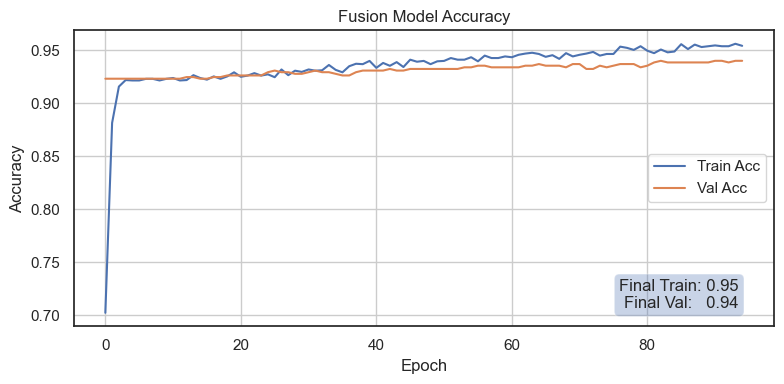

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
🔍 Sample Predictions (%):
[[ 0.08]
 [ 5.33]
 [14.76]
 [ 1.41]
 [ 0.41]
 [ 1.09]
 [ 2.42]
 [ 0.05]
 [ 0.17]
 [16.69]]


In [54]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

rs = 42

# ── 1) Load Clinical Dataset ──────────────────────────────────────────────────
clinical_path = "/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/merged_clinical_full.csv"
merged_clinical_df = pd.read_csv(clinical_path)
merged_clinical_df.columns = merged_clinical_df.columns.str.strip().str.lower()

X_merged_clinical = merged_clinical_df.drop(columns=["t2d"])
y_merged_clinical = merged_clinical_df["t2d"]

# ── 2) Load and Clean Genetic Dataset ─────────────────────────────────────────
merged_genetic_df = pd.concat([inter_genetic, normal_genetic], ignore_index=True)
merged_genetic_df.columns = merged_genetic_df.columns.str.strip().str.lower()

if "t2d" not in merged_genetic_df.columns:
    raise ValueError("❌ 't2d' column not found in genetic data.")

non_numeric_cols = merged_genetic_df.drop(columns=["t2d"]).select_dtypes(exclude=["number"]).columns.tolist()
print("🚫 Dropping non-numeric columns in genetic data:", non_numeric_cols)
genetic_numeric_df = merged_genetic_df.drop(columns=non_numeric_cols)

# Drop columns with >50% NaNs
threshold = 0.5
na_ratio = genetic_numeric_df.isna().mean()
cols_to_drop = na_ratio[na_ratio > threshold].index.tolist()
genetic_numeric_df.drop(columns=cols_to_drop, inplace=True)
print(f"📉 Dropped columns with >50% NaNs: {cols_to_drop}")

# Fill remaining NaNs
X_genetic = genetic_numeric_df.drop(columns=["t2d"]).fillna(genetic_numeric_df.median(numeric_only=True))
y_genetic = genetic_numeric_df["t2d"].loc[X_genetic.index].reset_index(drop=True)
X_genetic = X_genetic.reset_index(drop=True)

print(f"✅ Final cleaned genetic dataset: {X_genetic.shape[0]} samples, {X_genetic.shape[1]} features")

# ── 3) Train-test Split ───────────────────────────────────────────────────────
X_train_merged_clinical, X_test_merged_clinical, y_train_clinical, y_test_clinical = train_test_split(
    X_merged_clinical, y_merged_clinical, test_size=0.2, stratify=y_merged_clinical, random_state=rs
)

X_train_genetic, X_test_genetic, y_train_genetic, y_test_genetic = train_test_split(
    X_genetic, y_genetic, test_size=0.2, stratify=y_genetic, random_state=rs
)

# ── 4) Scale ──────────────────────────────────────────────────────────────────
scaler_clinical = StandardScaler()
X_train_merged_clinical_sc = scaler_clinical.fit_transform(X_train_merged_clinical)
X_test_merged_clinical_sc = scaler_clinical.transform(X_test_merged_clinical)

scaler_genetic = StandardScaler()
X_train_genetic_sc = scaler_genetic.fit_transform(X_train_genetic)
X_test_genetic_sc = scaler_genetic.transform(X_test_genetic)

# ── 5) SMOTE on Clinical ──────────────────────────────────────────────────────
sm = SMOTE(random_state=rs)
X_train_merged_clinical_sc, y_train_clinical = sm.fit_resample(X_train_merged_clinical_sc, y_train_clinical)

# ── 6) Align Training Sizes ───────────────────────────────────────────────────
min_len = min(len(X_train_merged_clinical_sc), len(X_train_genetic_sc))
X_train_merged_clinical_sc = X_train_merged_clinical_sc[:min_len]
X_train_genetic_sc = X_train_genetic_sc[:min_len]
y_train = y_train_clinical[:min_len]
print(f"✅ Matching training input sizes: {min_len} samples")

# ── 7) Align Testing Sizes ────────────────────────────────────────────────────
min_test_len = min(len(X_test_merged_clinical_sc), len(X_test_genetic_sc))
X_test_merged_clinical_sc = X_test_merged_clinical_sc[:min_test_len]
X_test_genetic_sc = X_test_genetic_sc[:min_test_len]
y_test = y_test_clinical[:min_test_len]
print(f"✅ Matching test input sizes: {min_test_len} samples")

X_tr_inputs = [X_train_merged_clinical_sc, X_train_genetic_sc]
X_te_inputs = [X_test_merged_clinical_sc, X_test_genetic_sc]

# ── 8) Fusion Model ───────────────────────────────────────────────────────────
def build_branch(input_dim, l2_reg=1e-3):
    inp = Input(shape=(input_dim,))
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(inp)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    proj = Dense(32, kernel_regularizer=l2(l2_reg))(inp)
    x = Add()([x, proj])
    x = BatchNormalization()(x)
    return inp, x

branches = [build_branch(X_train_merged_clinical_sc.shape[1]), build_branch(X_train_genetic_sc.shape[1])]
inputs, feats = zip(*branches)

merged = Concatenate()(feats)
se = Dense(merged.shape[-1] // 16, activation="relu")(merged)
se = Dense(merged.shape[-1], activation="sigmoid")(se)
x = Multiply()([merged, se])
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=list(inputs), outputs=out)
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss="binary_crossentropy", metrics=["accuracy"])

# ── 9) Training ───────────────────────────────────────────────────────────────
class TimeLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self._start
        print(f"Epoch {epoch+1:03d} | loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f} | val_loss={logs['val_loss']:.4f}, val_acc={logs['val_accuracy']:.4f} | {dt:.2f}s")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    TimeLogger()
]

history = model.fit(
    X_tr_inputs, y_train,
    validation_data=(X_te_inputs, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

# ── 10) Plot Accuracy ─────────────────────────────────────────────────────────
train_final = history.history["accuracy"][-1]
val_final = history.history["val_accuracy"][-1]

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.text(0.95, 0.05, f"Final Train: {train_final:.2f}\nFinal Val:   {val_final:.2f}", transform=plt.gca().transAxes, ha="right", va="bottom", bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))
plt.title("Fusion Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ── 11) Predict as Percentage ─────────────────────────────────────────────────
preds = model.predict(X_te_inputs)
preds_percent = preds * 100
print("🔍 Sample Predictions (%):")
print(np.round(preds_percent[:10], 2))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
21/21 ━━━━━━━━━━━━━━

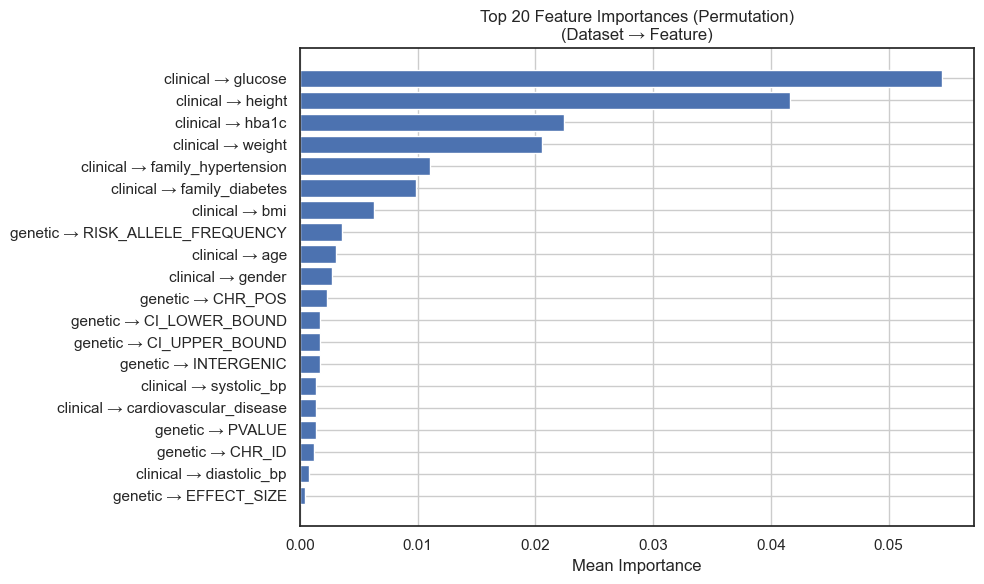

In [65]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# ── 1) Wrapper Class ───────────────────────────────────────────────────────────
class FusionModelWrapper:
    def __init__(self, model, modalities, dims):
        self.model = model
        self.modalities = modalities
        self.dims = dims

    def predict(self, X):
        inputs = []
        start = 0
        for m in self.modalities:
            dim = self.dims[m]
            inputs.append(X[:, start:start + dim])
            start += dim
        probs = self.model.predict(inputs).flatten()
        return (probs >= 0.5).astype(int)

    def fit(self, X, y):
        pass  # Required for sklearn compatibility

# ── 2) Feature Names ──────────────────────────────────────────────────────────
feature_names = []

for col in X_merged_clinical.columns:
    feature_names.append(f"clinical → {col}")

for col in X_genetic.columns:
    feature_names.append(f"genetic → {col}")

# ── 3) Prepare Data ───────────────────────────────────────────────────────────
modalities = ["clinical", "genetic"]  # matches X_te_inputs
X_dims = {m: X_te_inputs[i].shape[1] for i, m in enumerate(modalities)}
X_te_concat = np.concatenate(X_te_inputs, axis=1)

# ── 4) Run Permutation Importance ─────────────────────────────────────────────
fusion_wrapper = FusionModelWrapper(model, modalities, X_dims)

result = permutation_importance(
    fusion_wrapper,
    X_te_concat,
    y_test,
    n_repeats=10,
    random_state=rs,
    scoring='accuracy'
)

# ── 5) Format and Plot Results ────────────────────────────────────────────────
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

print(importances_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"].head(20), importances_df["Importance"].head(20))
plt.xlabel("Mean Importance")
plt.title("Top 20 Feature Importances (Permutation)\n(Dataset → Feature)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/100
49/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5058 - loss: 0.3961 Epoch 001 | loss=0.3790, acc=0.6112 | val_loss=0.3527, val_acc=0.9217 | 1.99s
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5356 - loss: 0.3908 - val_accuracy: 0.9217 - val_loss: 0.3527 - learning_rate: 1.0000e-04
Epoch 2/100
48/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7679 - loss: 0.3577 Epoch 002 | loss=0.3518, acc=0.8073 | val_loss=0.3359, val_acc=0.9232 | 0.13s
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - loss: 0.3559 - val_accuracy: 0.9232 - val_loss: 0.3359 - learning_rate: 1.0000e-04
Epoch 3/100
50/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8457 - loss: 0.3425 Epoch 003 | loss=0.3358, acc=0.8631 | val_loss=0.3228, val_acc=0.9232 | 0.13s
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8509 - loss: 0.3405 - val_accuracy: 0.9232 - val_loss: 0.3228 - learning_rate: 1.0000e-04
Epoch 4/100
50/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8913 - loss: 0.32

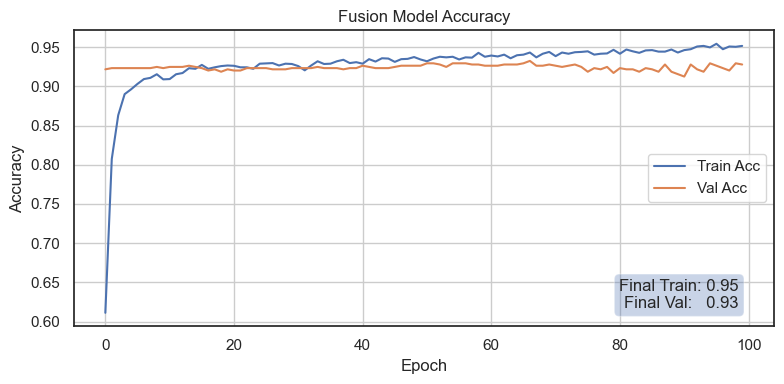

In [70]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, precision_recall_curve

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

rs = 42

# ── 1) Load and filter datasets ───────────────────────────────────────────────
important_clinical_cols = [
    "age", "pulse_rate", "systolic_bp", "diastolic_bp", "glucose", "hba1c", "bmi",
    "family_diabetes", "hypertensive", "family_hypertension", "cardiovascular_disease",
    "stroke", "gender", "weight", "height"
]

merged_clinical_df = merged_clinical_df[important_clinical_cols + ["t2d"]]
X_merged_clinical = merged_clinical_df.drop(columns=["t2d"])
y_merged_clinical = merged_clinical_df["t2d"]

important_genetic_cols = [
    "CHR_ID", "CHR_POS", "RISK_ALLELE_FREQUENCY", "INTERGENIC",
    "CI_LOWER_BOUND", "CI_UPPER_BOUND", "EFFECT_SIZE", "PVALUE_MLOG", "PVALUE"
]

inter_genetic_filtered = inter_genetic[important_genetic_cols]
normal_genetic_filtered = normal_genetic[important_genetic_cols]

genetic_df = pd.concat([inter_genetic_filtered, normal_genetic_filtered], ignore_index=True)

# ── 2) SMOTE on clinical ──────────────────────────────────────────────────────
X_train_merged_clinical, _, y_train_merged_clinical, _ = train_test_split(
    X_merged_clinical, y_merged_clinical, test_size=0.2, stratify=y_merged_clinical, random_state=rs
)
scaler_clinical = StandardScaler()
X_train_merged_clinical_sc = scaler_clinical.fit_transform(X_train_merged_clinical)

sm = SMOTE(random_state=rs)
X_bal = {}
y_bal = {}
X_bal["merged_clinical"], y_bal["merged_clinical"] = sm.fit_resample(X_train_merged_clinical_sc, y_train_merged_clinical)

# ── 3) Downsample genetic ─────────────────────────────────────────────────────
min_len = min(len(X_bal["merged_clinical"]), len(genetic_df))
X_bal["merged_clinical"] = X_bal["merged_clinical"][:min_len]
y_bal["merged_clinical"] = y_bal["merged_clinical"][:min_len]
genetic_df_downsampled = genetic_df.sample(n=min_len, random_state=rs).reset_index(drop=True)

# ── 4) Train-test split and scaling ───────────────────────────────────────────
X_clinical = X_bal["merged_clinical"]
X_genetic = genetic_df_downsampled
y = y_bal["merged_clinical"]

X_train_clin, X_test_clin, X_train_gen, X_test_gen, y_train, y_test = train_test_split(
    X_clinical, X_genetic, y, test_size=0.2, stratify=y, random_state=rs
)

scaler_clin = StandardScaler().fit(X_train_clin)
scaler_gen = StandardScaler().fit(X_train_gen)

X_train_clin_sc = scaler_clin.transform(X_train_clin)
X_test_clin_sc = scaler_clin.transform(X_test_clin)
X_train_gen_sc = scaler_gen.transform(X_train_gen)
X_test_gen_sc = scaler_gen.transform(X_test_gen)

X_tr_inputs = [X_train_clin_sc, X_train_gen_sc]
X_te_inputs = [X_test_clin_sc, X_test_gen_sc]

# ── 5) Compute Class Weights ──────────────────────────────────────────────────
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# ── 6) Focal Loss (optional) ──────────────────────────────────────────────────
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt, gamma) * bce)
    return loss_fn

# ── 7) Build Fusion Model ─────────────────────────────────────────────────────
def build_branch(input_dim, l2_reg=1e-3):
    inp = Input(shape=(input_dim,))
    x = Dense(64, activation="relu", kernel_regularizer=l2(l2_reg))(inp)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    proj = Dense(32, kernel_regularizer=l2(l2_reg))(inp)
    x = Add()([x, proj])
    x = BatchNormalization()(x)
    return inp, x

branches = [build_branch(X_train_clin_sc.shape[1]), build_branch(X_train_gen_sc.shape[1])]
inputs, feats = zip(*branches)

merged = Concatenate()(feats)
se = Dense(merged.shape[-1] // 16, activation="relu")(merged)
se = Dense(merged.shape[-1], activation="sigmoid")(se)
x = Multiply()([merged, se])
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=list(inputs), outputs=out)
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), 
              loss=focal_loss(),  # or use "binary_crossentropy"
              metrics=["accuracy"])

# ── 8) Train ──────────────────────────────────────────────────────────────────
class TimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self._start
        print(f"Epoch {epoch+1:03d} | loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f} | val_loss={logs['val_loss']:.4f}, val_acc={logs['val_accuracy']:.4f} | {dt:.2f}s")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    TimeLogger()
]

history = model.fit(
    X_tr_inputs, y_train,
    validation_data=(X_te_inputs, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights
)

# ── 9) Plot Accuracy ─────────────────────────────────────────────────────────
train_final = history.history["accuracy"][-1]
val_final = history.history["val_accuracy"][-1]

plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.text(0.95, 0.05, f"Final Train: {train_final:.2f}\nFinal Val:   {val_final:.2f}", transform=plt.gca().transAxes, ha="right", va="bottom", bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))
plt.title("Fusion Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📍 Threshold = 0.3
Confusion Matrix:
 [[529  72]
 [ 16  34]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9706    0.8802    0.9232       601
           1     0.3208    0.6800    0.4359        50

    accuracy                         0.8648       651
   macro avg     0.6457    0.7801    0.6796       651
weighted avg     0.9207    0.8648    0.8858       651


📍 Threshold = 0.35
Confusion Matrix:
 [[546  55]
 [ 21  29]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9630    0.9085    0.9349       601
           1     0.3452    0.5800    0.4328        50

    accuracy                         0.8833       651
   macro avg     0.6541    0.7442    0.6839       651
weighted avg     0.9155    0.8833    0.8964       651


📍 Threshold = 0.4
Confusion Matrix:
 [[568  33]
 [ 25  25]]
Classification Report:
               precision    recall  f1-score   suppo

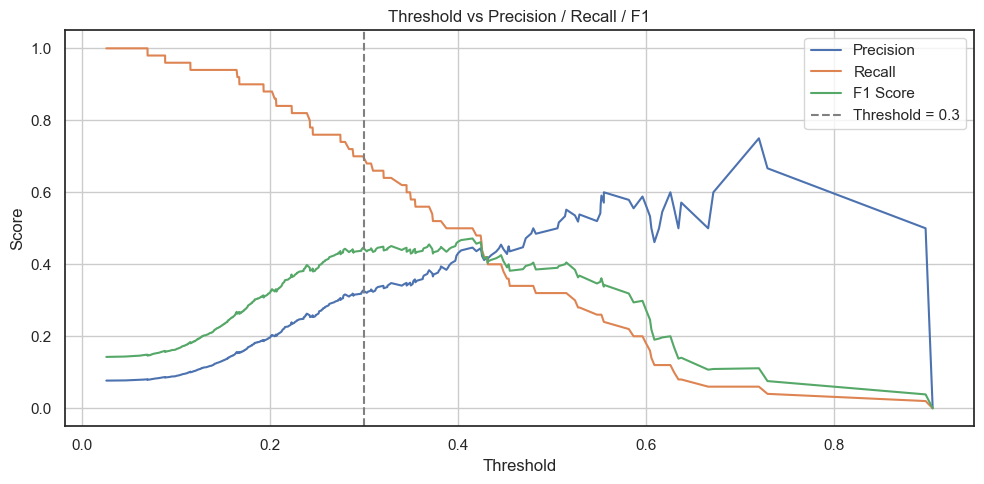


✅ Best threshold by F1: 0.4154 (F1: 0.4717)

📋 Final Report Using Best Threshold:
              precision    recall  f1-score   support

           0     0.9580    0.9484    0.9532       601
           1     0.4464    0.5000    0.4717        50

    accuracy                         0.9140       651
   macro avg     0.7022    0.7242    0.7124       651
weighted avg     0.9187    0.9140    0.9162       651



In [57]:
# ── 1. Define focal loss (optional: already used in training) ─────────────────
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return K.mean(alpha * K.pow(1. - pt, gamma) * bce)
    return loss_fn

# ── 2. Get model predictions and actual labels ────────────────────────────────
# MUST be called after training and model.predict
preds = model.predict(X_te_inputs).flatten()
# y_test must already be defined from your earlier train/test split

# ── 3. Evaluate predictions at different thresholds ───────────────────────────
thresholds_to_test = [0.3, 0.35, 0.4, 0.45, 0.5]
results = []

for threshold in thresholds_to_test:
    pred_labels = (preds >= threshold).astype(int)
    report = classification_report(y_test, pred_labels, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, pred_labels)

    print(f"\n📍 Threshold = {threshold}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, pred_labels, digits=4, zero_division=0))

    results.append({
        'Threshold': threshold,
        'Precision (class 1)': report['1']['precision'],
        'Recall (class 1)': report['1']['recall'],
        'F1-score (class 1)': report['1']['f1-score'],
        'Support (class 1)': report['1']['support'],
        'Overall Accuracy': report['accuracy'],
        'Weighted F1-score': report['weighted avg']['f1-score']
    })

# ── 4. Show summary table and save to CSV ─────────────────────────────────────
results_df = pd.DataFrame(results)
print("\n📋 Summary of Threshold Performance:")
print(results_df)
results_df.to_csv("threshold_analysis.csv", index=False)

# ── 5. Plot Precision, Recall, F1 Score vs. Threshold ─────────────────────────
precision, recall, thresholds = precision_recall_curve(y_test, preds)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(0.3, color='gray', linestyle='--', label='Threshold = 0.3')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision / Recall / F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ── 6. (Optional) Automatically use best threshold by F1-score ────────────────
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\n✅ Best threshold by F1: {best_threshold:.4f} (F1: {f1_scores[best_idx]:.4f})")

final_preds = (preds >= best_threshold).astype(int)
print("\n📋 Final Report Using Best Threshold:")
print(classification_report(y_test, final_preds, digits=4))



✅ Best Threshold by Class 1 F1-Score: 0.40

📋 Final Classification Report using Best Threshold:
              precision    recall  f1-score   support

           0     0.9578    0.9451    0.9514       601
           1     0.4310    0.5000    0.4630        50

    accuracy                         0.9109       651
   macro avg     0.6944    0.7225    0.7072       651
weighted avg     0.9174    0.9109    0.9139       651



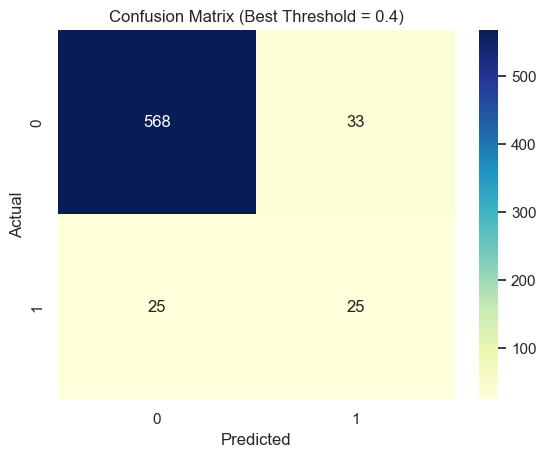

In [58]:
# Automatically find best threshold for class 1 F1-score
best_idx = np.argmax(results_df["F1-score (class 1)"])
best_threshold = results_df.loc[best_idx, "Threshold"]
print(f"\n✅ Best Threshold by Class 1 F1-Score: {best_threshold:.2f}")

# Evaluate model using this best threshold
final_preds = (preds >= best_threshold).astype(int)
print("\n📋 Final Classification Report using Best Threshold:")
print(classification_report(y_test, final_preds, digits=4))

# Optional: Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Confusion Matrix (Best Threshold = {best_threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [59]:
from sklearn.metrics import classification_report

# ── 10) Evaluate on test set ──────────────────────────────────────────────────
threshold = 0.3 # Lowered threshold to improve recall for class 1
y_pred_probs = model.predict(X_te_inputs).flatten()
y_pred = (y_pred_probs >= threshold).astype(int)

print(f"\n📋 Classification Report on Test Set (Threshold = {threshold}):")
print(classification_report(y_test, y_pred, digits=4))

# Optional: print prediction probabilities as percentages
print("\n🔍 Sample prediction probabilities (%):")
print(np.round(y_pred_probs[:10] * 100, 2))




21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step

📋 Classification Report on Test Set (Threshold = 0.3):
              precision    recall  f1-score   support

           0     0.9706    0.8802    0.9232       601
           1     0.3208    0.6800    0.4359        50

    accuracy                         0.8648       651
   macro avg     0.6457    0.7801    0.6796       651
weighted avg     0.9207    0.8648    0.8858       651


🔍 Sample prediction probabilities (%):
[ 7.36 12.95 35.21  8.56 10.63 22.87 20.69  8.85 12.    7.52]


# Saving model and scalers

In [60]:
# Save in Keras v3 native format
model.save('/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/fusion_model_final0.keras')


In [61]:
# ── 10) Save Model for Backend Integration ─────────────────────────────────────
model.save("fusion_model_percentage.h5")
print("✅ Model saved as fusion_model_percentage.h5")

# (Optional) Save scalers for consistent preprocessing in backend
import joblib
joblib.dump(scaler_clin, "scaler_clinical.save")
joblib.dump(scaler_gen, "scaler_genetic.save")
print("✅ Scalers saved: scaler_clinical.save, scaler_genetic.save")


✅ Model saved as fusion_model_percentage.h5
✅ Scalers saved: scaler_clinical.save, scaler_genetic.save
